In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import networkx as nx
import community
import os
from funciones import *
import scipy.misc
from scipy.sparse import csr_matrix
import scipy.sparse.csgraph as sc
import copy
import itertools

/usr/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


In [2]:
#------------------------------------------------------------------------------------------------------
#                                 Trabajo Computacional 3
#------------------------------------------------------------------------------------------------------

# Primero creamos la red de delfines: agregamos los enlaces sin necesidad de agregar antes los nodos
mydolphins = nx.read_gml('dolphins.gml')

# Para agregar el dato del genero a partir del txt:
# creamos dos listas: una de nombres de delfines (nodos) y otra de los generos correspondientes
Gender = pd.read_csv('dolphinsGender.txt', sep='\t', header=None)
delfines = Gender[0] # nombres de delfines (nodos)
genero = Gender[1]   # genero de los delfines en el mismo orden que los nodos

# A cada uno de los nodos ya existentes en el grafo, se le agrega el genero
for d,g in zip(delfines,genero):
    mydolphins.add_node(d, gender=g)
    
#Output folder:
outfolder='./resultados_fast_greedy/'

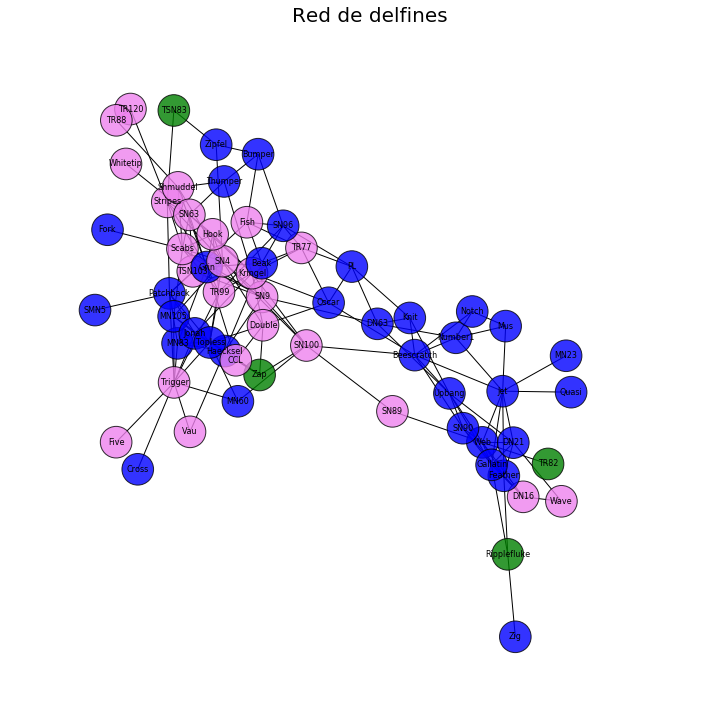

In [3]:
#------------------------------------------------------------------------------------------------------
#Grafico Original
#------------------------------------------------------------------------------------------------------
width=12
height=12
fig=plt.figure(figsize=(width, height))
fig.patch.set_facecolor('white')

#Posiciones de los nodos
#pos = nx.spring_layout(mydolphins)
#Asi siempre grafica lo mismo
pos={'TR77': [-0.00686432,  0.20671214], 'SN4': [-0.30167655,  0.1709983 ], 'MN105': [-0.48412144,  0.02281396], 'MN83': [-0.46944408, -0.04991709], 'Shmuddel': [-0.46766429,  0.36944462], 'Vau': [-0.42298501, -0.28769828], 'SN90': [ 0.59618263, -0.27801198], 'Bumper': [-0.16871511,  0.4586046 ], 'SMN5': [-0.77760313,  0.0395804 ], 'Stripes': [-0.50783091,  0.3303615 ], 'Quasi': [ 1.        , -0.18112197], 'DN16': [ 0.82094776, -0.46242208], 'Whitetip': [-0.66190052,  0.43242722], 'Fork': [-0.73091456,  0.25552539], 'Grin': [-0.36074806,  0.15523022], 'PL': [0.18131467, 0.15653464], 'DN21': [ 0.78411834, -0.31682214], 'Trigger': [-0.48236803, -0.1548581 ], 'SN89': [ 0.33282518, -0.23263502], 'Oscar': [0.09453741, 0.05925168], 'Fish': [-0.21062552,  0.27569265], 'SN63': [-0.42534403,  0.29564573], 'SN100': [ 0.0114244 , -0.05565292], 'SN9': [-0.15391299,  0.07498991], 'TR99': [-0.31469055,  0.08795352], 'CCL': [-0.25197153, -0.09534079], 'DN63': [0.27664047, 0.00265266], 'Topless': [-0.34901076, -0.04751828], 'Upbang': [ 0.54549589, -0.1844215 ], 'TR82': [ 0.91382896, -0.37402259], 'Knit': [0.39761589, 0.01846514], 'Zap': [-0.16312988, -0.13489098], 'Jet': [ 0.74434305, -0.1784962 ], 'Double': [-0.15038254, -0.00120439], 'Cross': [-0.61803759, -0.38844752], 'Hook': [-0.3384137 ,  0.24327099], 'Wave': [ 0.96374634, -0.47444471], 'Mus': [ 0.75550099, -0.00351393], 'TR120': [-0.64532706,  0.57999096], 'Patchback': [-0.49964881,  0.08446744], 'SN96': [-0.07512146,  0.26618326], 'Gallatin': [ 0.70301601, -0.37641514], 'Five': [-0.69876631, -0.31554103], 'Notch': [0.63079813, 0.03576706], 'Beak': [-0.15531096,  0.16553754], 'Kringel': [-0.19166107,  0.13881005], 'Web': [ 0.66849069, -0.31601452], 'Scabs': [-0.45119676,  0.20397036], 'MN60': [-0.24415948, -0.20565683], 'Number1': [ 0.56972977, -0.03490899], 'Thumper': [-0.29542824,  0.38534941], 'TSN83': [-0.48332259,  0.57613593], 'TSN103': [-0.41262492,  0.14370002], 'MN23': [ 0.98120322, -0.0832051 ], 'Feather': [ 0.74874531, -0.4058308 ], 'Jonah': [-0.40488327, -0.02305368], 'TR88': [-0.69803733,  0.54972405], 'Zig': [ 0.79160867, -0.83867743], 'Beescratch': [ 0.41616125, -0.08156713], 'Haecksel': [-0.29259803, -0.07059502], 'Zipfel': [-0.32524628,  0.48412704], 'Ripplefluke': [ 0.76341264, -0.61701228]}

#Nodos
#nx.draw_networkx_nodes(mydolphins,pos,nodelist=mydolphins.nodes(),node_color=["blue" if g=='m' else "violet" if g=='f' else "green" for g in nx.get_node_attributes(mydolphins, "gender").values()],with_labels=True,node_size=1000,alpha=0.8)
nx.draw_networkx_nodes(mydolphins,pos,nodelist=list(delfines),node_color=["blue" if g=='m' else "violet" if g=='f' else "green" for g in list(genero)],with_labels=True,node_size=1000,alpha=0.8)

#Enlaces
nx.draw_networkx_edges(mydolphins,pos,width=1.0,alpha=1)

#Etiquetas
nx.draw_networkx_labels(mydolphins,pos,font_size=8)
plt.title('Red de delfines',fontsize=20)
plt.axis('off')
plt.show()

In [4]:
#------------------------------------------------------------------------------------------------------
#Metodo: Fast Greedy
#------------------------------------------------------------------------------------------------------
comus = nx.algorithms.community.greedy_modularity_communities(mydolphins, weight=None)
comunidades=list(comus)
print(comunidades)

[frozenset({'Shmuddel', 'Thumper', 'Fork', 'SN96', 'Beak', 'Kringel', 'SN63', 'Hook', 'TSN83', 'TR77', 'Bumper', 'TR88', 'Grin', 'SN9', 'SN4', 'Scabs', 'Stripes', 'Fish', 'Whitetip', 'TR99', 'TR120', 'Zipfel', 'TSN103'}), frozenset({'PL', 'Quasi', 'Number1', 'DN63', 'Gallatin', 'Oscar', 'Zig', 'Wave', 'DN16', 'Notch', 'Jet', 'Upbang', 'MN23', 'TR82', 'Mus', 'Feather', 'DN21', 'Ripplefluke', 'Web', 'Knit', 'Beescratch', 'SN90'}), frozenset({'Patchback', 'MN83', 'MN60', 'Zap', 'CCL', 'Topless', 'SMN5', 'Haecksel', 'MN105', 'Vau', 'Five', 'Double', 'Jonah', 'Trigger', 'Cross'}), frozenset({'SN100', 'SN89'})]


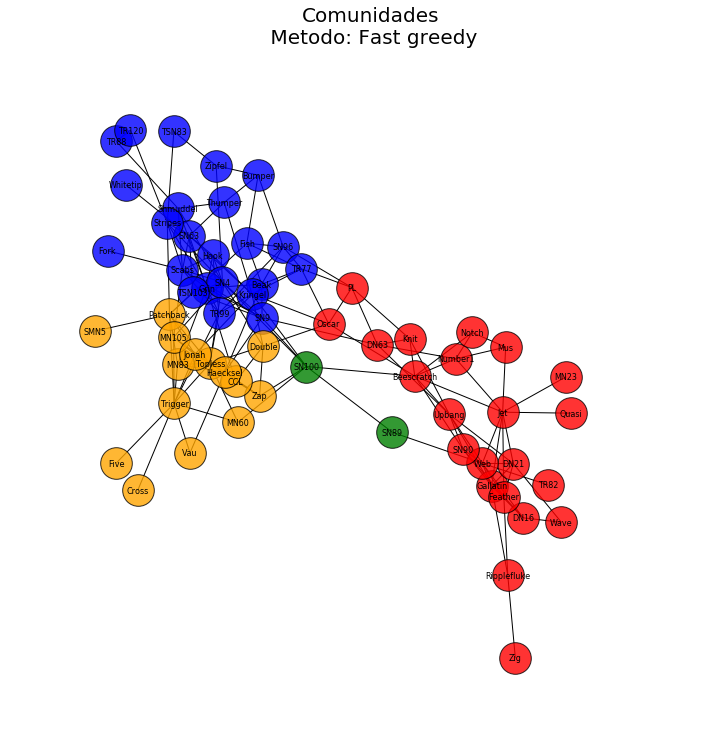

In [5]:
#------------------------------------------------------------------------------------------------------
#1.a)Visualice los resultados gráficamente
#------------------------------------------------------------------------------------------------------
colores=['blue','red','orange','green']
width=12
height=12
fig = plt.figure(figsize=(width, height))
fig.patch.set_facecolor('white')

#Nodos
for c,comu in enumerate(comunidades):
    nx.draw_networkx_nodes(mydolphins,pos,nodelist=comu,node_color=colores[c],node_size=1000,alpha=0.8)

#Enlaces
nx.draw_networkx_edges(mydolphins,pos,width=1.0,alpha=1)

#Etiquetas
nx.draw_networkx_labels(mydolphins,pos,font_size=8)
plt.title('Comunidades\n Metodo: Fast greedy',fontsize=20)
plt.axis('off')

plt.show()

In [6]:
#-------------------------------------------------------------------------------
#1.b) Modularidad y Silouhette:
#-------------------------------------------------------------------------------
#Asignamos a cada nodo del grafo la propiedad comunity que tendrá un color.

for c,comu in enumerate(comunidades):
    for delfin in list(comu):
        mydolphins.node[delfin]['comunity']=colores[c]
#-------------------------------------------------------------
#Modularidad:
#-------------------------------------------------------------
#Matriz de Adyacencias Aij:
delfines=mydolphins.nodes()
A = np.array(nx.to_numpy_matrix(mydolphins,nodelist=delfines))
N=mydolphins.number_of_nodes()
m=mydolphins.number_of_edges()
grado = dict(mydolphins.degree())

#Matriz de variable categorica comunidad: Cij=delta(ci,cj)
C=np.zeros(np.shape(A))
for ni, idelfin in enumerate(delfines):
    for nj, jdelfin in enumerate(delfines):
        if mydolphins.nodes[idelfin]['comunity']==mydolphins.nodes[jdelfin]['comunity']:
            C[ni,nj]=1

#Calculo de la modularidad
#Q/Qmax=(S1-S2)*(1/2m)

#S1=Suma en nodos (Aij*Cij)
#S2=Suma en nodos(kikj*Cij/2m)
S1=0
S2=0

for ni, idelfin in enumerate(delfines):
    for nj, jdelfin in enumerate(delfines):  
        S1=S1+A[ni,nj]*C[ni,nj]
        S2=S2+grado[idelfin]*grado[jdelfin]*C[ni,nj]
S2=S2/(2*m)
mod=(S1-S2)/(2*m)

print('Modularidad = {0:.3f}'.format(mod))


Modularidad = 0.495


In [7]:
#Calculando la modularidad de cada comunidad:
modularidades=[]
for c,comu in enumerate(comunidades):
    s1=0
    s2=0
    for idelfin in list(comu):
        for jdelfin in list(comu):
            #Buscamos los indices en la lista de delfines para luego acceder a la matrix de Ady con esos indices ni y nj:
            ni=[idx for idx,d in enumerate(delfines) if d==idelfin]
            nj=[idx for idx,d in enumerate(delfines) if d==jdelfin]
            s1=s1+A[ni,nj]
            s2=s2+grado[idelfin]*grado[jdelfin]
    s2=s2/(2*m)
    mod=(s1-s2)/(2*m)
    modularidades.append(float(mod))

print('Modularidades por comunidad:')
print(modularidades)
print('Modularidad = {0:.3f}'.format(np.sum(modularidades)))

#Output
'''
output={}
output['color']=colores
output['mod']=modularidades
df=pd.DataFrame(output)
df.to_csv(outfolder+'modularidades.txt',sep='\t')
'''

Modularidades por comunidad:
[0.16877299157470038, 0.19271389581108342, 0.12851548593805623, 0.005488311380087813]
Modularidad = 0.495


"\noutput={}\noutput['color']=colores\noutput['mod']=modularidades\ndf=pd.DataFrame(output)\ndf.to_csv(outfolder+'modularidades.txt',sep='\t')\n"

Silhouette S[i]=
[('Shmuddel', 0.23478260869565215), ('PL', 0.03141711229946514), ('Thumper', 0.21739130434782608), ('Fork', 0.23043478260869574), ('SN96', 0.17285259809119838), ('Beak', 0.2), ('Kringel', -0.21590909090909094), ('Zap', -0.16666666666666669), ('TR82', -0.05172413793103444), ('SN63', 0.30434782608695654), ('DN63', 0.1454545454545455), ('Gallatin', 0.32727272727272727), ('Jonah', 0.3587878787878787), ('Hook', 0.25217391304347825), ('Oscar', -0.05172413793103444), ('TSN83', 0.25652173913043486), ('Quasi', 0.16666666666666666), ('TR88', 0.24223602484472057), ('TR77', 0.04347826086956523), ('Bumper', 0.3217391304347827), ('Zig', 0.2525252525252525), ('Mus', 0.24242424242424235), ('Grin', 0.308300395256917), ('Vau', 0.4299145299145299), ('Number1', 0.21818181818181817), ('Five', 0.3714285714285714), ('SN9', -0.23333333333333334), ('SN4', -0.15853658536585363), ('Wave', 0.24675324675324678), ('Scabs', 0.29192546583850937), ('DN16', 0.054545454545454494), ('Notch', -0.035087719

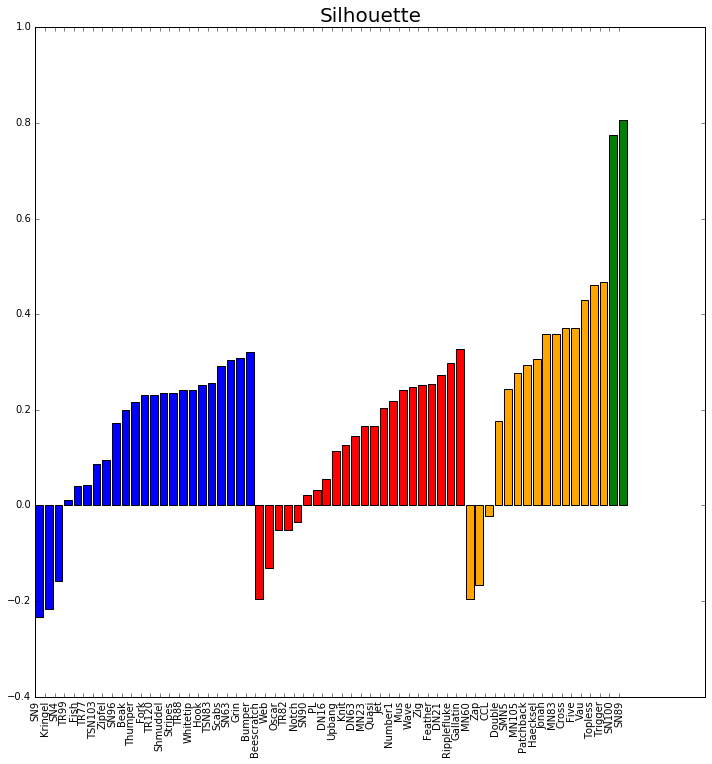

In [8]:
#-------------------------------------------------------------
#Silhouette:
#-------------------------------------------------------------
#distancia promedio de un nodo a todos los de su comunidad
#distancia se podria medir como el numero de links en el camino mas corto para llegar a otro.
#Ej:
#distancia entre 'Jet' y 'Trigger' = len(nx.shortest_path(mydolphins,'Jet','Trigger')) - 1

#Calculo de a[i]
a=[] #contendra para cada nodo en delfines la distancia promedio a nodos de su misma comunidad
for idelfin in delfines:
    distancias=[]
    for jdelfin in delfines:
        if mydolphins.nodes[idelfin]['comunity']==mydolphins.nodes[jdelfin]['comunity']:
               distancias.append(len(nx.shortest_path(mydolphins,idelfin,jdelfin))-1)         
    promedio=np.mean(distancias)
    a.append(promedio)

#Calculo de b[i]
b=[] #contendria para cada nodo en delfines la distancia promedio a nodos de otras comunidades, devuelvo  el promedio minimo
for idelfin in delfines: 
    #Me quedo con las comunidades distintas a la del delfin idelfin
    comuni=['blue','red','orange','green']
    comuni.remove(mydolphins.node[idelfin]['comunity'])
    b_comuni=[]
    for c in comuni:
        distancias=[]
        for jdelfin in delfines:
            if mydolphins.nodes[jdelfin]['comunity']==c:
                distancias.append(len(nx.shortest_path(mydolphins,idelfin,jdelfin))-1)
        promedio_comuni=np.mean(distancias)
        b_comuni.append(promedio_comuni)
    b.append(min(b_comuni))
    comuni=['blue','red','orange','green'] #vuelvo a comuni al inicial

#Calculo el Silhouette:
S=[]
for i,idelfin in enumerate(delfines):
    s=(b[i]-a[i])/(max(b[i],a[i]))
    S.append(s)
    #guardo la propiedad silhouette en el grafo:
    mydolphins.node[idelfin]['silhouette']=s
print('Silhouette S[i]=')
print (mydolphins.nodes.data('silhouette'))

#Output
'''
df = pd.DataFrame.from_dict(dict(mydolphins.nodes.data('silhouette')), orient="index")
df.to_csv(outfolder+'silhouette.txt',sep='\t')
'''

#Grafico de Silhouette:
width=12
height=12
plt.figure(figsize=(width, height))
delfines=np.sort(delfines)
x = []
xTicks = []
contador=-1
dtype = [('name', 'S21'), ('silhouette', float)]
for c in colores:
    delf_S=[] #lista con pares de [delfin,silouette]
    for i, idelfin in enumerate(delfines):
        if mydolphins.nodes[idelfin]['comunity']==c:
            delf_S.append((str(idelfin),mydolphins.nodes[idelfin]['silhouette']))        
    delf_S=np.array(delf_S,dtype=dtype)
    delf_S=np.sort(delf_S,order='silhouette') #lo ordeno segun la propiedad silhouette
    delf_S=list(delf_S)
    for j,d in enumerate(delf_S):
        contador=contador+1
        delfin=str(delf_S[j][0],'utf-8')
        silhouette_value=delf_S[j][1]
        plt.bar(contador,silhouette_value,color=mydolphins.nodes[delfin]['comunity'])#grafico una barra
        x.append(contador)
        xTicks.append(delfin)
plt.xticks(x, xTicks)
plt.xticks(range(len(delfines)),xTicks, rotation=90)
plt.title('Silhouette',fontsize=20)
plt.show()

In [54]:
#------------------------------------------------------------------------------
#1b) Rewirings:
#------------------------------------------------------------------------------
#Se podria tomar la red original recablear, y luego para las comunidades encontradas
#en la red original contar los enlaces que se hayan entre esos nodos.
#O sea estariamos calculando de forma simulada el valor kikj/2L.
#Haremos un histograma del numero de enlaces en esa comunidad.

#iteraciones=20000 #descomentar para que corra
Recableados={} #es un diccionario que tiene como keys ['comunidadi'] y como propiedades['color','lc_real','lc_random'].
               #lc_random es una lista de tamano 'iteraciones' y que contiene el numero de enlaces dentro de esa comunidadn uno de esos recableados
lc_random=[[],[],[],[]]


#Recableamos y contamos enlaces en cada comunidad
for it in range(0,iteraciones):
    D=rewiring(mydolphins) #creamos un nuevo grafo recableado:
    D_ady = np.array(nx.to_numpy_matrix(D,nodelist=delfines))
    for c,comu in enumerate(comunidades):
        enlaces=0
        for idelfin in list(comu):
            for jdelfin in list(comu):
                #Buscamos los indices en la lista de delfines para luego acceder a la matrix de Ady con esos indices ni y nj:
                ni=[idx for idx,d in enumerate(delfines) if d==idelfin]
                nj=[idx for idx,d in enumerate(delfines) if d==jdelfin]
                enlaces=enlaces+D_ady[ni,nj]
        lc_random[c].append(int(enlaces)/2)
        Recableados['comunidad'+str(c)]={'color':colores[c],'lc_real':0,'lc_random':list(lc_random[c])}

#Contamos enlaces en cada comunidad de la red original:
modularidad_rewiring
for c,comu in enumerate(comunidades):
        enlaces=0
        for idelfin in list(comu):
            for jdelfin in list(comu):
                #Buscamos los indices en la lista de delfines para luego acceder a la matrix de Ady con esos indices ni y nj:
                ni=[idx for idx,d in enumerate(delfines) if d==idelfin]
                nj=[idx for idx,d in enumerate(delfines) if d==jdelfin]
                enlaces=enlaces+A[ni,nj]
        enlaces=int(enlaces)/2
        Recableados['comunidad'+str(c)]['lc_real']=enlaces

#Graficamos:
'''
for c,comu in enumerate(comunidades):
    plt.figure(c)
    plt.hist(Recableados['comunidad'+str(c)]['lc_random'],color=colores[c],linewidth=1.5,edgecolor='black',label='Red recableada',alpha=0.8,normed=1)
    plt.axvline(x=Recableados['comunidad'+str(c)]['lc_real'],color=colores[c],linewidth=2,label='Red Real')
    plt.xlabel('$Numero$ $de$ $enlaces$ $dentro$ $de$ $la$ $comunidad$')
    plt.ylabel('$Frecuencia$')
    plt.legend(loc='upper center')
    plt.title('Modularidad '+' comunidad '+colores[c])
    plt.savefig(outfolder+'comunidad_'+colores[c]+'_hist.png')
'''    

#Output
'''
for c,comu in enumerate(comunidades):
    lc_real=Recableados['comunidad'+str(c)]['lc_real'] #numero de enlaces dentro de la comunidad en la red real
    lc_rewiring=np.mean(Recableados['comunidad'+str(c)]['lc_random'])#numero de enlaces promedio dentro de la comunidad para un cierto numero de redes recableadas.
    modularidad_por_rewiring=(lc_real-lc_rewiring)/m #dividimos por el numero de enlaces totales.
    output={}
    output['comunidad']=Recableados['comunidad'+str(c)]['color']
    output['enlaces_red_real']=lc_real
    output['enlaces_red_recabelada']=lc_rewiring
    output['modularidad por rewiring']=modularidad_por_rewiring
    output['modularidad por cuenta teorica']=modularidades[c]
    output['enlaces_red_random']=list(Recableados['comunidad'+str(c)]['lc_random'])
    df = pd.DataFrame.from_dict(output, orient="index")
    df.to_csv(outfolder+'comunidad_'+colores[c]+'_data.txt',sep='\t')
'''

NameError: name 'iteraciones' is not defined

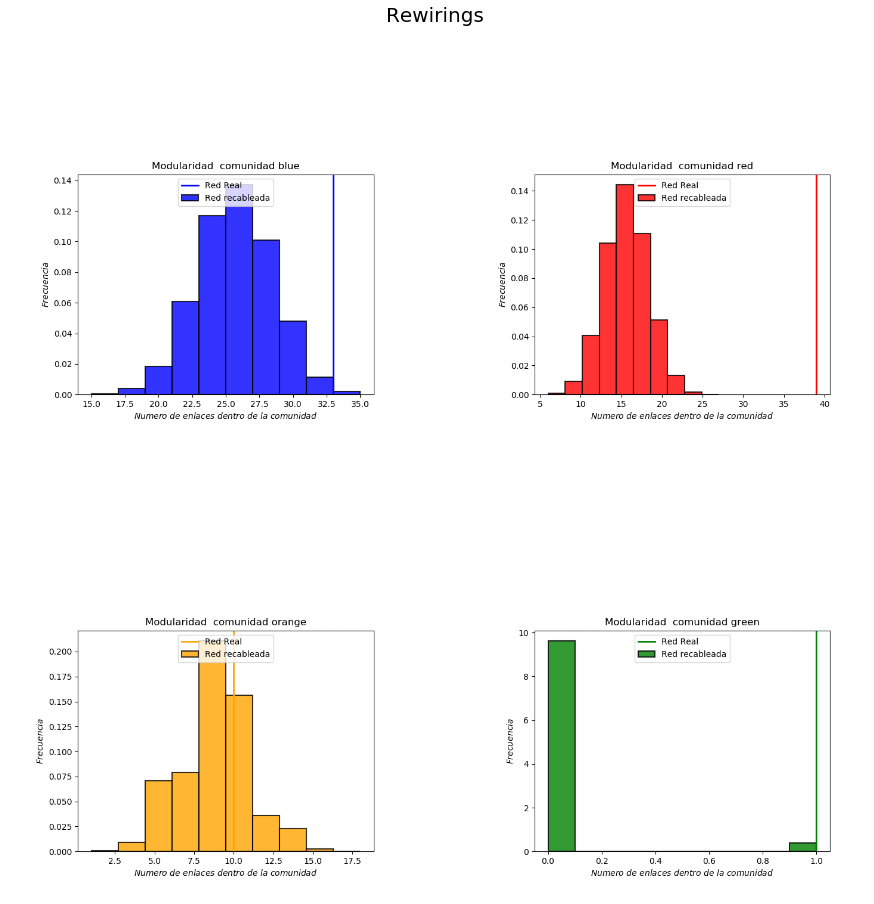

In [22]:
plt.figure(figsize=(15,15))
plt.suptitle('Rewirings',fontsize=20)
plt.subplot(2,2,1)
blue=plt.imread('resultados_fast_greedy/comunidad_blue_hist.png')
plt.imshow(blue)
plt.axis('off')

plt.subplot(2,2,2)
red=plt.imread('resultados_fast_greedy/comunidad_red_hist.png')
plt.imshow(red)
plt.axis('off')

plt.subplot(2,2,3)
orange=plt.imread('resultados_fast_greedy/comunidad_orange_hist.png')
plt.imshow(orange)
plt.axis('off')

plt.subplot(2,2,4)
green=plt.imread('resultados_fast_greedy/comunidad_green_hist.png')
plt.imshow(green)
plt.axis('off')

plt.show()

In [23]:
#Se hicieron 20000 recableados en cada red y en cada uno contamos la cantidad de enlaces dentro de cada comunidad:
#Los resultados estan en la carpeta resultados_fast_greedy.

enlaces_red_real=[33,39,10,1]
enlaces_red_rewiring=[25.2,15.7,8.8,0.038]#valor medio del histograma
modularidad_rewiring=[0.0489,0.146,0.007,0.006]


In [25]:
#-----------------------------------------------------------------------------------------------------------------------------
#1d)Tests de Fisher para ver la relacion entre genero y comunidades encontradas:
#-----------------------------------------------------------------------------------------------------------------------------
Generos={} 
#Es  un diccionario que tiene como keys ['comunidadi'] y como propiedades['color','dc','fc','mc','pFish','pvalor'].
#dc: numero de delfines en la comunidad. 
#fc: numero de hembras en la comunidad.
#mc: numero de machos en la comunidad.
#pFish: probabilidad de que hayan hc hembras en la comunidad por azar. pFish=(F fc)(D-F dc-fc)/(D dc)  donde (A a)=A!/a!(A-a)!
#D: numero total de delfines con genero f o m
#F: numero total de hembras
#M: numero total de machos

delfinesF=[delfines[i] for i,idelfin in enumerate(delfines) if mydolphins.node[idelfin]['gender']=='f']
delfinesM=[delfines[i] for i,idelfin in enumerate(delfines) if mydolphins.node[idelfin]['gender']=='m']
F=len(delfinesF)
M=len(delfinesM)
D=M+F

for c,comu in enumerate(comunidades):
    dc=0
    fc=0
    mc=0
    for idelfin in list(comu):
        if mydolphins.node[idelfin]['gender']=='f':
            dc=dc+1
            fc=fc+1
        elif mydolphins.node[idelfin]['gender']=='m':
            dc=dc+1
            mc=mc+1
    pFish=scipy.misc.comb(F,fc)*scipy.misc.comb(D-F,dc-fc)/scipy.misc.comb(D,dc)
    #Calculo del pvalor:
    pvalor=0
    for f in range(fc,F+1):
        pvalor=pvalor+(scipy.misc.comb(F,f)*scipy.misc.comb(D-F,dc-f)/scipy.misc.comb(D,dc))
    Generos['comunidad'+str(c)]={'color':colores[c],'dc':dc,'fc':fc,'mc':mc,'pFish':pFish,'pvalor':pvalor}
    
#Para chequear que este bien la cuenta se puede usar:
#import scipy.stats as stats    
#scipy.stats.fisher_exact(table, alternative='less')
#donde la tabla de contingencias es: Comunidad/Nocomunidad     Machos/Hembras
#[[mc,fc],[M-mc,F-fc]]
    
#Output
'''
df = pd.DataFrame.from_dict(dict(Generos), orient="index")
df.to_csv(outfolder+'generos.txt',sep='\t')
'''


'\ndf = pd.DataFrame.from_dict(dict(Generos), orient="index")\ndf.to_csv(outfolder+\'generos.txt\',sep=\'\t\')\n'

In [26]:
Generos



{'comunidad0': {'color': 'blue',
  'dc': 23,
  'fc': 15,
  'mc': 8,
  'pFish': 0.00269788584395019,
  'pvalor': 0.0032049208787337862},
 'comunidad1': {'color': 'red',
  'dc': 19,
  'fc': 2,
  'mc': 17,
  'pFish': 0.0006798995698764223,
  'pvalor': 0.9999422036385638},
 'comunidad2': {'color': 'orange',
  'dc': 14,
  'fc': 5,
  'mc': 9,
  'pFish': 0.2197970236711812,
  'pvalor': 0.7882824282705964},
 'comunidad3': {'color': 'green',
  'dc': 2,
  'fc': 2,
  'mc': 0,
  'pFish': 0.16696914700544466,
  'pvalor': 0.16696914700544466}}

In [28]:
dc=[22,20,14,2]#numero de delfines totales en cada comunidad
fc=[15,2,5,2]#numero de hembras en cada comunidad
mc=[7,18,9,0]#numero de machos en cada comunidadish
pFish=[0.0027,0.0007,0.22,0.166]#probabilidad del test de Fischer
pvalor=[0.0032,0.999,0.788,0.166]#p-valor

tabla_resumen = pd.DataFrame({"Comunidades":["Blue","Red","Orange","Green"],
                    "Modularidad (teórica)":modularidades,
                    "Modularidad (rewiring)":modularidad_rewiring,
                    "Enlaces (red real)":enlaces_red_real,
                    "Enlaces (red rewiring)":enlaces_red_rewiring,
                    "Ndelfines":dc,
                    "Nhembras":fc,
                    "Nmachos":mc,
                    "pFischer":pFish,
                    "pValor":pvalor,
                   })
tabla_resumen

,Comunidades,Enlaces (red real),Enlaces (red rewiring),Modularidad (rewiring),Modularidad (teórica),Ndelfines,Nhembras,Nmachos,pFischer,pValor
0,Blue,33,25.200,0.0489,0.168348,22,15,7,0.0027,0.0032
1,Red,39,15.700,0.1460,0.189975,20,2,18,0.0007,0.9990
2,Orange,10,8.800,0.0070,0.128515,14,5,9,0.2200,0.7880
3,Green,1,0.038,0.0060,0.005488,2,2,0,0.1660,0.1660


Clique Percolation...
comunidad final
[['Mus', 'Notch', 'Number1'], ['Mus', 'Number1', 'Jet'], ['Notch', 'Number1', 'Beescratch'], ['Number1', 'Jet', 'Beescratch']]
comunidad final
[['Beak', 'Fish', 'TR77'], ['Oscar', 'Kringel', 'Double'], ['Oscar', 'Kringel', 'TR77'], ['Oscar', 'PL', 'TR77'], ['PL', 'SN96', 'TR77'], ['SN96', 'Beak', 'Fish'], ['SN96', 'Beak', 'TR77'], ['SN96', 'Bumper', 'Fish'], ['SN96', 'Fish', 'TR77']]
comunidad final
[['Grin', 'Hook', 'TR99'], ['Grin', 'SN4', 'Hook'], ['Grin', 'SN4', 'Scabs'], ['Grin', 'SN4', 'Shmuddel'], ['Grin', 'SN4', 'Stripes'], ['Grin', 'SN63', 'Hook'], ['Grin', 'SN63', 'Scabs'], ['Grin', 'SN63', 'Stripes'], ['Grin', 'SN63', 'TSN103'], ['Grin', 'SN9', 'Beak'], ['Grin', 'SN9', 'SN4'], ['Grin', 'SN9', 'Scabs'], ['Grin', 'SN9', 'TSN103'], ['Grin', 'Scabs', 'Hook'], ['Grin', 'Scabs', 'Shmuddel'], ['Grin', 'Scabs', 'Stripes'], ['Grin', 'Scabs', 'TR99'], ['Kringel', 'Hook', 'TR99'], ['MN60', 'Topless', 'Trigger'], ['MN83', 'Haecksel', 'Jonah'], ['MN8

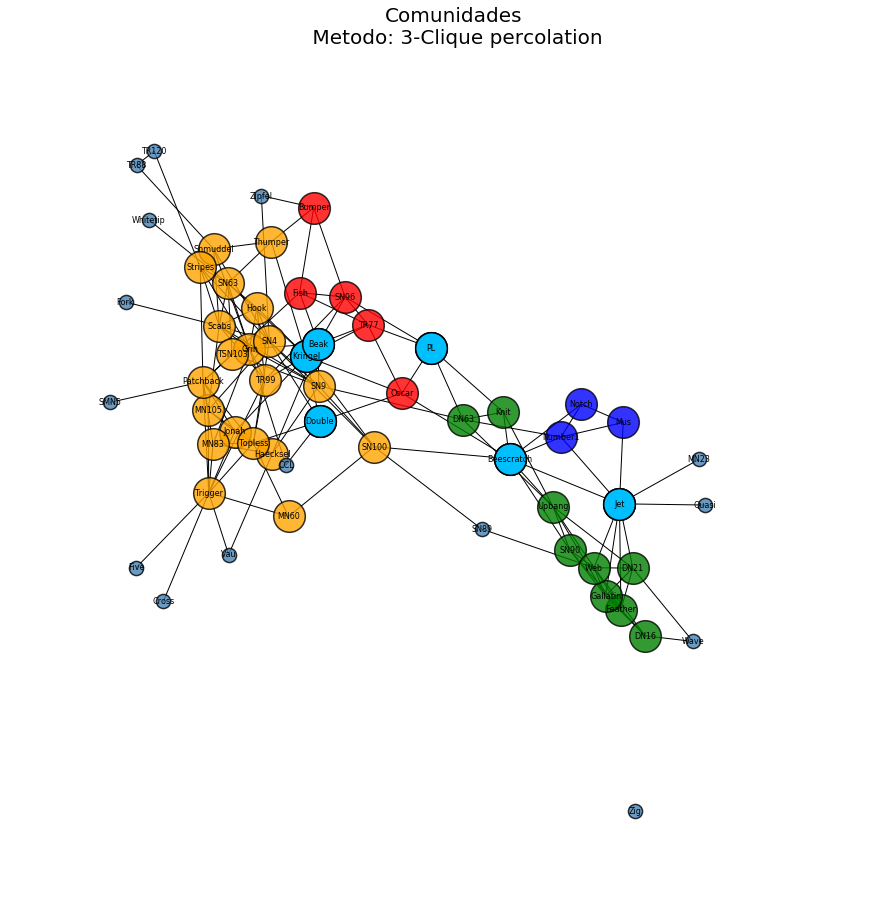

In [20]:
#-----------------------------------------------------------------------------------------------------------------------------
#2)k-Clique Percolation:
#-----------------------------------------------------------------------------------------------------------------------------
#-----------------------------------------------------------------------------------------------------------------------------
#Parte A) Calculos previos:
#-----------------------------------------------------------------------------------------------------------------------------
print('Clique Percolation...')
cliques=list(nx.enumerate_all_cliques(mydolphins))
k=3 #Tipo de k-cliques que queremos percolar.
cliques_k=[] #nos quedamos con los k_cliques.
for c,clique in enumerate(cliques):
    if len(clique)==k:
        cliques_k.append(clique)

#CLiques_k es la matriz de Overlap de k-cliques:
Cliques_k=np.zeros((len(cliques_k),len(cliques_k)))

for i,iclique in enumerate(cliques_k):
    for j,jclique in enumerate(cliques_k):
        if len(set(iclique).intersection(set(jclique)))==k-1:#dos 3-cliques se overlapean si son adyacentes o sea si comparten un link.
            Cliques_k[i][j]=1
            Cliques_k[j][i]=1

#Usamos el algoritmo de reverse_cuthill_mckee para generar una matriz de bloques:(creo que debe ser similar a hacer formad de Jordan este algoritmo)
#(No creo que sea del todo necesario pero creo que reduce el tiempo de computo para lo que viene despues)
            
A=Cliques_k

A=np.array(A)
B=csr_matrix(A) #Cliques_tres en forma sparse para poder pasarselo al metodo se necesita la matriz en esta forma
C=np.zeros((np.shape(A)[0],np.shape(A)[0]))
orden=sc.reverse_cuthill_mckee(B,symmetric_mode=True) #ordena los vectores columna en la matriz A de forma de obtener una matriz C de bloques.
orden=list(orden)
for i,o in enumerate(orden):
    for j,p in enumerate(orden):
        C[i,j]=A[o][p]

#cliques hay que ordenarlo segun el vector orden.
cliques_k_ordenados=[]
for c,clique in enumerate(cliques_k):
    nuevo=copy.deepcopy(cliques_k[orden[c]])
    cliques_k_ordenados.append(nuevo)

#-----------------------------------------------------------------------------------------------------------------------------
#Parte B) Percolacion de cliques:
#-----------------------------------------------------------------------------------------------------------------------------
#Hasta aca tenemos cliques_tres_ordenados.
#Ahora tenemos que encontrar las comunidades:
#Hago una copia de cliques que tengo:

cliques=copy.deepcopy(cliques_k_ordenados) #lo copiamos ya que vamos a ir eliminando cliques de la lista cliques pero cliques_tres_ordenados la conservamos intacta

#Estrategia: vamos buscando cliques en la lista cliques y cuando son adyaentes los agarro y los agrego a la lista comunidad_cliques
Comunidades=[]
comunidad_cliques=[copy.deepcopy(cliques[0])] #acá es donde vamos a ir poniendo los cliques que vamos encontrando que son adyacentes
                                              #el valor inicial de la comunidad_cliques son los delfines del primer clique de la lista cliques

while len(cliques)>1: #terminamos cuando se me acabaron los cliques en a lista cliques
    cliques_to_remove=[] #cuando encuentro que hay una interseccion entre el jclique con algno de la comunidad lo tengo que eliminar de la lista cliques
    cliques_to_remove.append(0)#asi elimino tambien el primer elemento
    #print('cliques actualizados:')
    #print(cliques)

    tamanocliquesold=len(cliques) 
    tamanocliquesnew=len(cliques)+1
    
    #Lo siguiente es MUCHO MUY IMPORTANTE!:
    #una vez que termino te recorrer cliques y agregarlos a comunidad_cliques hay que aseguarse que no queden cliques en la lista clique que puedan corresponder
    #a la comunidad que estoy armando en comunidad_cliques.
    #esto puede pasar porque el link compartido se pudo formar despues y nunca lo vi,mos entonces...hay que iterar hasta que el largo del vector comunidad_cliques ya no cambie.

    while tamanocliquesnew-tamanocliquesold > 0: #Hay que iterar hasta que este vector ya no cambie mas su largo!!: 
        tamanocliquesold=len(comunidad_cliques)  
        for j in range(0,len(cliques)):
            for cc, cclique in enumerate(comunidad_cliques):
                if len(set(cliques[j]).intersection(set(cclique)))==k-1:
                    comunidad_cliques.append(cliques[j])#guardo el clique en vez de los nodos y siempre comparo con cliques NO con nodos
                    cliques_to_remove.append(j)
                    #eliminamos elementos repetidos tanto de remove como de comunidad_cliques
                    comunidad_cliques.sort()
                    comunidad_cliques=list(comunidad_cliques for comunidad_cliques,_ in itertools.groupby(comunidad_cliques))#elimino elementos repetidos
                    #print('comunidad')
                    #print(comunidad_cliques)
                    cliques_to_remove=list(np.unique(cliques_to_remove))
                    #print(cliques_to_remove)
        tamanocliquesnew=len(comunidad_cliques)
                   
    newcliques= [z for i, z in enumerate(cliques) if i not in cliques_to_remove] #actualizamos cliques borrando los que ya encontramos que hubo interseccion
    cliques=copy.deepcopy(newcliques)
 
    print('comunidad final')
    print(comunidad_cliques) 
               
    Comunidades.append(comunidad_cliques)
    if len(cliques)>0:
        comunidad_cliques=[copy.deepcopy(cliques[0])]
 
print('Listo Clique Percolation')

#-----------------------------------------------------------------------------------------------------------------------------
#Parte C) post-Calculos :
#-----------------------------------------------------------------------------------------------------------------------------

numero_comunidades=len(Comunidades)
print('Numero de comunidades encontradas: {}'.format(numero_comunidades))

#Teminamos de armar las comunidades a partir de los cliques que estan en cada component de Comunidades[i]:
comunidades_perc=[] #lista que contiene en cada posicion una comunidad que es la lista de delfines que pertenecen a la misma
delfines_alcanzados=[]

for c,com in enumerate(Comunidades):
    delfines=[]
    for cl, clique in enumerate(com):
        for grado in range(0,k):
            delfines.append(clique[grado])
            delfines_alcanzados.append(clique[grado])
    comunidades_perc.append(list(np.unique(delfines)))
    
delfines_alcanzados=list(np.unique(delfines_alcanzados))

for c,com in enumerate(Comunidades):
    print('Comunidad {}: numerodecliques: {} numerodedelfines: {}'.format(c,len(com),len(comunidades_perc[c])))

#Nodos overlapping:
overlap_comunidades=[]
for c,icom in enumerate(comunidades_perc):
    overlap_row=[]
    for d,jcom in enumerate(comunidades_perc):
        if c!=d:
            overlap_row.append(list(set(icom).intersection(set(jcom))))
        else:
            overlap_row.append([])
    overlap_comunidades.append(overlap_row)

#Nodos faltantes: son nodos a los que el metodo no pudo llegar los vamos a graficar en tamaño mas chico:
#comparamos con la lista de delfines_alcanzados con la lista de delfines
delfines_originales=mydolphins.nodes()
delfines_faltantes=set(delfines_originales).difference(set(delfines_alcanzados))

#----------------------------------------    
#Grafico:
#----------------------------------------

colores=['blue','red','orange','green']

fig = plt.figure(figsize=(15,15))
fig.patch.set_facecolor('white')

#Nodos alcanzados por clique percolation
for c,comu in enumerate(comunidades_perc):
    nx.draw_networkx_nodes(mydolphins,pos,nodelist=comu,node_color=colores[c],node_size=1000,alpha=0.8,linewidths=1.5,edgecolors='black')

#Nodos con overlapping entre comunidades:
for i in range(0,len(overlap_comunidades)):
   for j in range(i,len(overlap_comunidades)): 
    nx.draw_networkx_nodes(mydolphins,pos,nodelist=overlap_comunidades[i][j],node_color='deepskyblue',node_shape='o',node_size=1000,alpha=1,linewidths=1.5,edgecolors='black')   

#Nodos faltantes:
nx.draw_networkx_nodes(mydolphins,pos,nodelist=delfines_faltantes,node_color='steelblue',node_size=200,alpha=0.8,linewidths=1.5,edgecolors='black')

#Enlaces
nx.draw_networkx_edges(mydolphins,pos,width=1.0,alpha=1)

#Etiquetas
nx.draw_networkx_labels(mydolphins,pos,font_size=8)
plt.title('Comunidades\n Metodo: '+str(k)+'-Clique percolation',fontsize=20)
plt.axis('off')
plt.show()



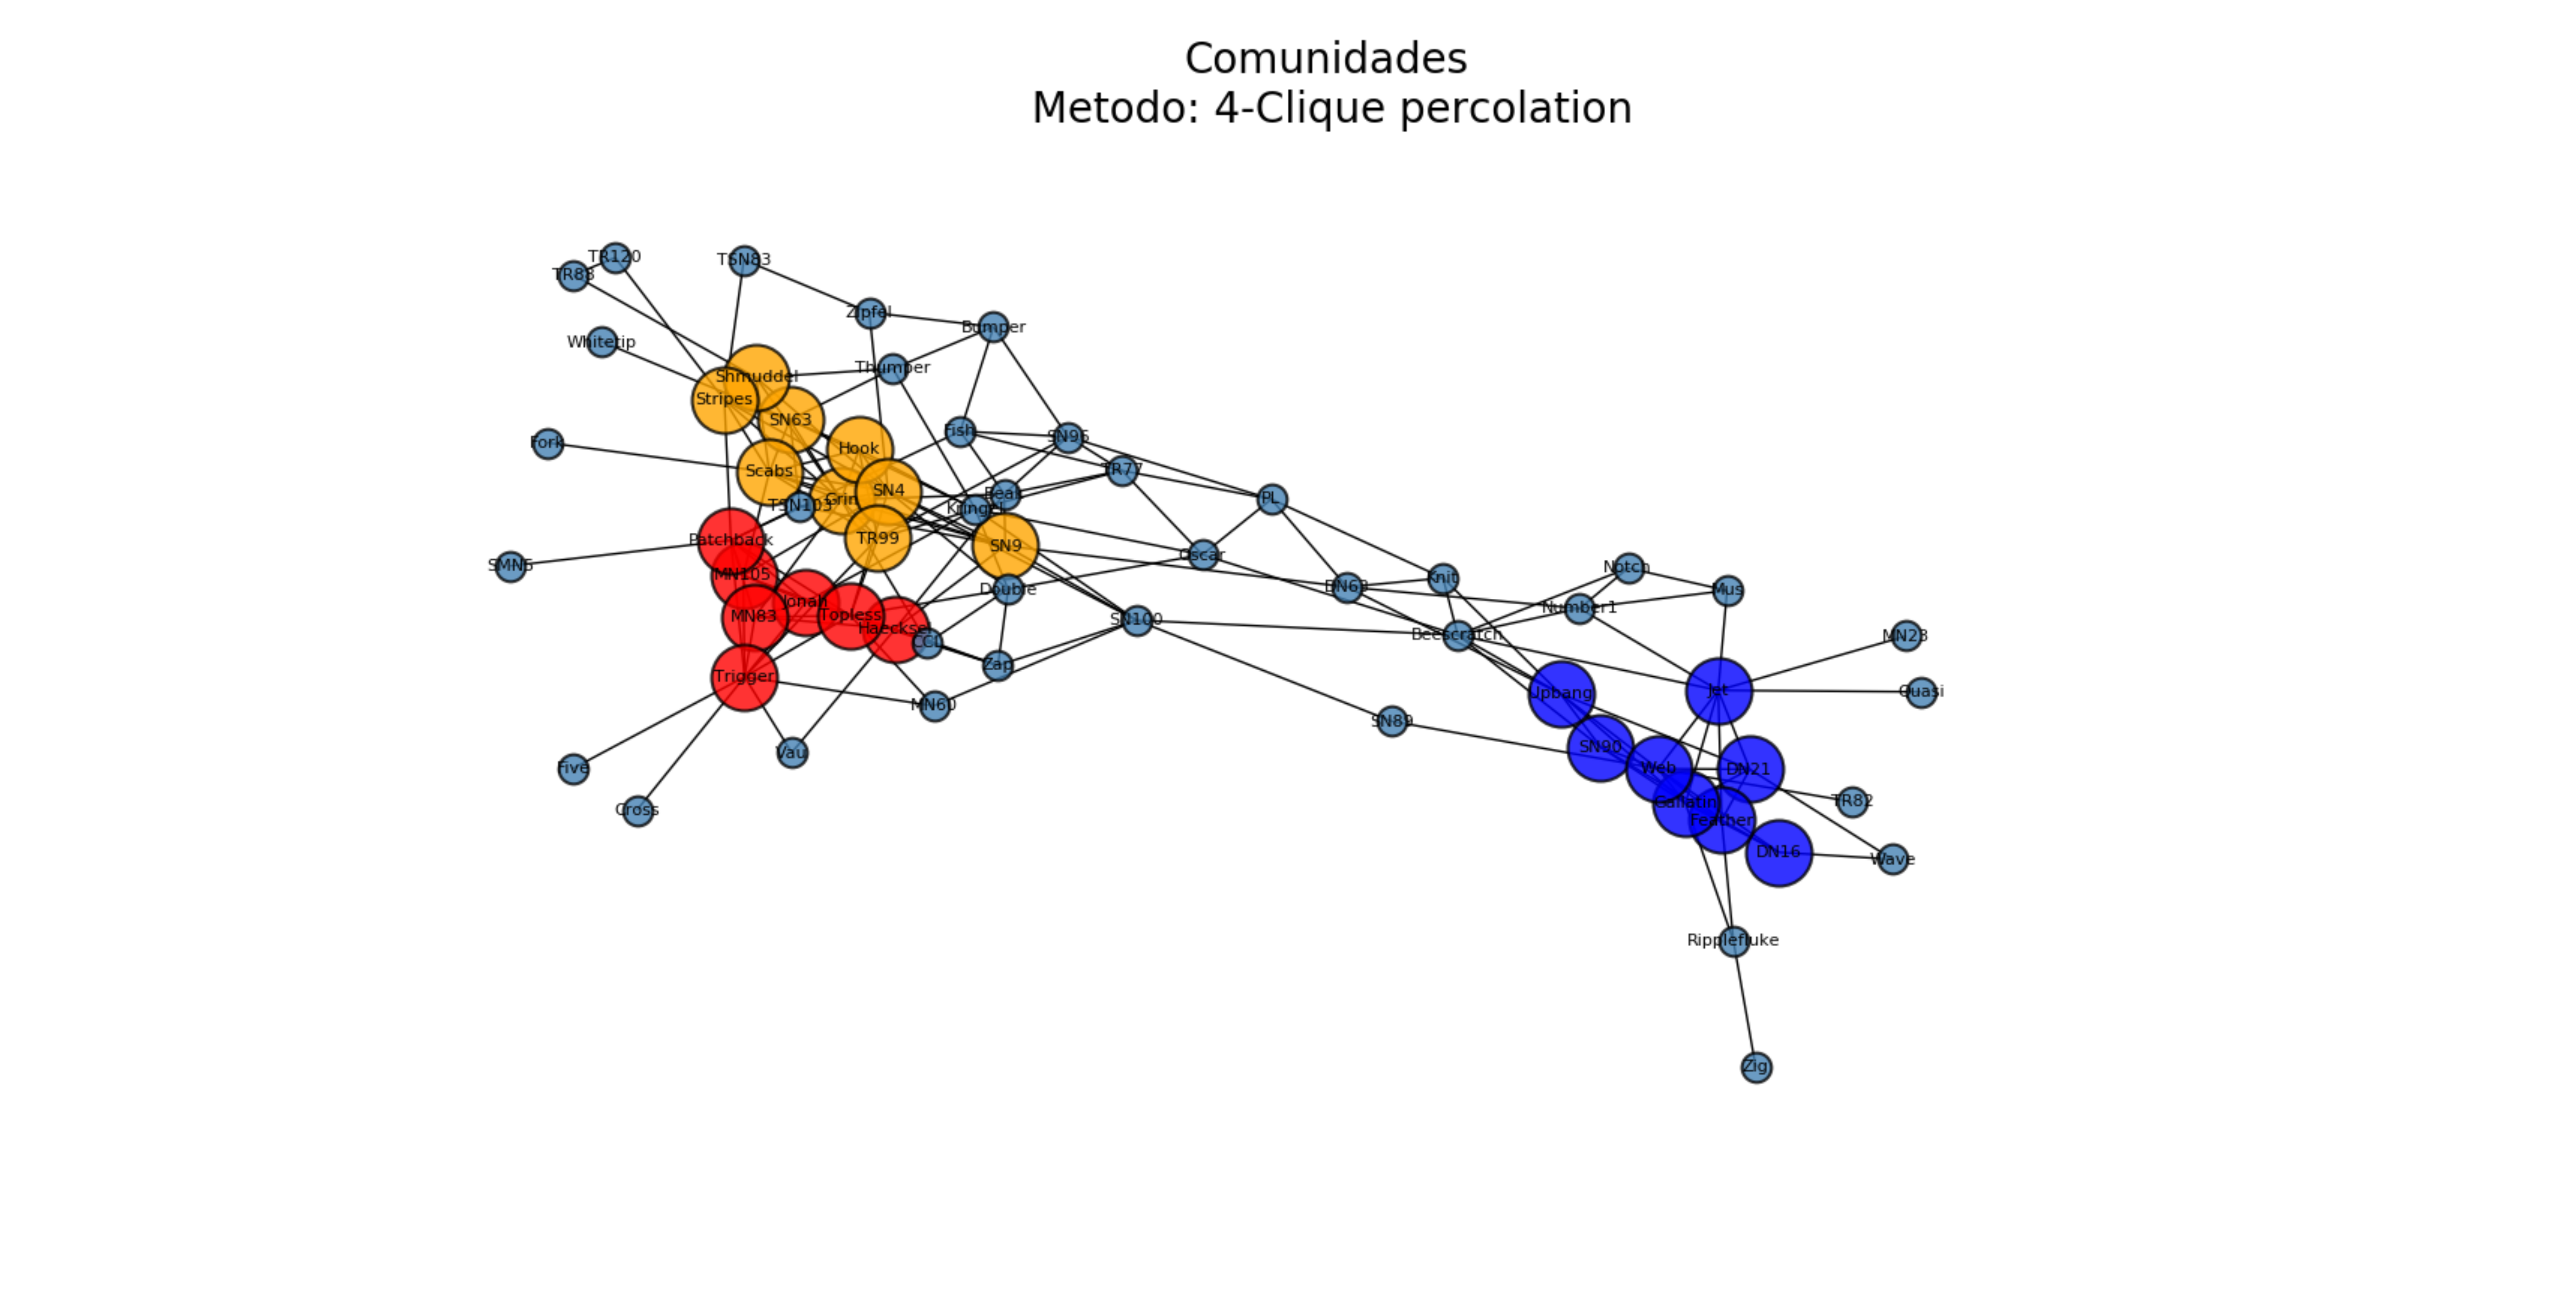

In [30]:
plt.figure(figsize=(100,100))
four_cliqueperc=plt.imread('resultados_fast_greedy/comunidad_4cliqueperc.png')
plt.imshow(four_cliqueperc)
plt.axis('off')
plt.show()

Calculando Homofilia en comunidades
Comunidad:0
Distribucion de enlaces fm:
Valor medio(H null): 26.64
Desviacion Standar: 3.49
Valor Red Real: 23.00
p valor: 0.1214


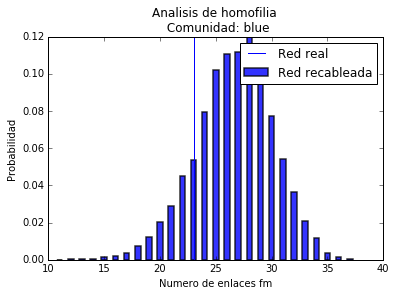

Comunidad:1
Distribucion de enlaces fm:
Valor medio(H null): 15.67
Desviacion Standar: 3.90
Valor Red Real: 8.00
p valor: 0.0169


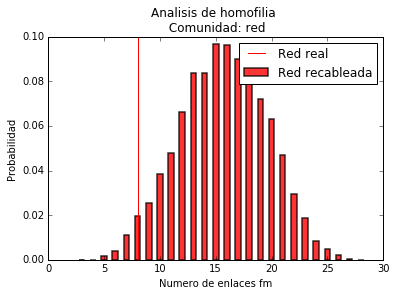

Comunidad:2
Distribucion de enlaces fm:
Valor medio(H null): 16.82
Desviacion Standar: 2.59
Valor Red Real: 13.00
p valor: 0.0514


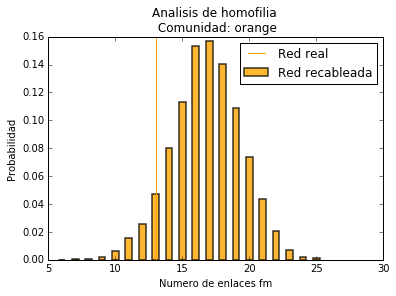

Comunidad:3
Distribucion de enlaces fm:
Valor medio(H null): 0.00
Desviacion Standar: 0.00
Valor Red Real: 0.00
p valor: 0.0000


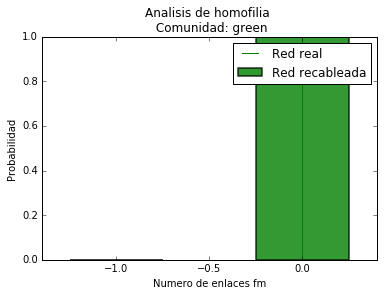

In [9]:
#-----------------------------------------------------------------------------------------------------------------------------
#1d)Extras Analisis de homofilia:
#-----------------------------------------------------------------------------------------------------------------------------
#Vamos a hacerlo de dos maneras al igual que lo que hicimos en el tp1:
#a) Utilizando primero una reasignacion de los generos dentro de cada comunidad
#y comparando con la cantidad de enlaces entre distintos generos(numero de enlaces fm)
#de la red real.
print('Calculando Homofilia en comunidades')

Enlaces_fm_comunidades= [] # Lista donde vamos a almacenar la cantidad de enlaces entre géneros distintos
Enlaces_fm_comunidad=[]

Generos_comunidades=[]
Generos_comunidad=[]

mean_enlacesfm_comunidades=[]
desv_enlacesfm_comunidades=[]

histogramas_comunidades=[]
pvalue_comunidades=[]

for c,com in enumerate(comunidades):
    Generos_comunidad=[]
    for d,delfin in enumerate(com):
        Generos_comunidad.append(mydolphins.nodes[delfin]['gender'])
    Generos_comunidades.append(Generos_comunidad)

Comunity_graphs=[]


for i,icom in enumerate(comunidades):
    Comunity_graph=copy.deepcopy(mydolphins)
    for j,jcom in enumerate(comunidades):
        if j!=i:
            Comunity_graph.remove_nodes_from(jcom)
    Comunity_graphs.append(Comunity_graph)


# Hacemos N asignaciones aleatorias de género:
num_asignaciones = 10000

for cg, comgraph in enumerate(Comunity_graphs):
    delfines=comunidades[cg]
    Enlaces_fm_comunidad= []
    for it in range(0,num_asignaciones):
        if it==0:
            genero_shuffle = Generos_comunidades[cg] # Conservamos la red real en la primera iteración
        else:
            genero_shuffle = Generos_comunidades[cg] 
            np.random.shuffle(genero_shuffle) # Reordenamos aleat los generos para el resto de las iteraciones

        #Reasignamos a cada nodo un valor de genero del vector de genero_shuffle:
        for d,g in zip(delfines,genero_shuffle):
            Comunity_graphs[cg].add_node(d, gender=g)

        #Contamos la fraccion de enlaces que conecta nodos con diferente genero:
        enlaces = list(Comunity_graphs[cg].edges.data())
        enlaces_fm = 0 # Ponemos en cero el contador de enlaces cruzados
        # Recorremos los enlaces y nos fijamos cual de ellos es del tipo f-m:
        for i in range(0,len(enlaces)):
            genero1 = Comunity_graphs[cg].nodes[enlaces[i][0]]['gender']
            genero2 = Comunity_graphs[cg].nodes[enlaces[i][1]]['gender']
            if (genero1 != genero2) & (genero1 is not float) & (genero2 is not float): 
                enlaces_fm += 1 # Incrementamos el contador si los generos son diferentes
        Enlaces_fm_comunidad.append(enlaces_fm) # Guardamos la cantidad de enlaces f-m en cada iteración
    Enlaces_fm_comunidades.append(Enlaces_fm_comunidad)

    # Ahora tenemos una lista Enlaces_fm con la cantidad de enlaces cruzados para N iteraciones
    # Recordamos que la primera componente corresponde a la red real

    # Valor medio y desviacion standar
    mean_enlacesfm = np.mean(Enlaces_fm_comunidad)
    mean_enlacesfm_comunidades.append(mean_enlacesfm)
    desv_enlacesfm = np.std(Enlaces_fm_comunidad)
    desv_enlacesfm_comunidades.append(desv_enlacesfm)
    
    print('Comunidad:{}'.format(cg))
    print ('Distribucion de enlaces fm:')
    print ('Valor medio(H null): {0:.2f}'.format(mean_enlacesfm))
    print ('Desviacion Standar: {0:.2f}'.format(desv_enlacesfm))
    print ('Valor Red Real: {0:.2f}'.format(Enlaces_fm_comunidad[0]))


    # Histograma y p-valor:
    histograma = np.unique(Enlaces_fm_comunidad,return_counts=True)
    histogramas_comunidades.append(histograma)
    k_enlacesfm = histograma[0] # El vector cantidad de enlaces fm, ordenado
    probabilidad = histograma[1]/float(num_asignaciones) # Cantidad de veces que aparece cada valor de enlaces, normalizado

    # p-valor: la probabilidad que queda acumulada a la izq del numero de enlaces_fm de la red real
    # Buscamos el k_enlacesfm mas cercano al de la red real
    closestto = Enlaces_fm_comunidad[0]
    theclosest = min(histograma[0], key=lambda x:abs(x-closestto)) # devuelve el k_enlacesfm más cercano al valor real
    theclosest_index = int(np.where(histograma[0] == theclosest)[0]) # devuelve el indice correspondiente al valor anterior

    # Sumamos las probabilidades desde el mas cercano hasta el ultimo hacia la derecha
    pvalue=1-np.sum(probabilidad[theclosest_index :])
    pvalue_comunidades.append(pvalue)
    print ('p valor: {0:.4f}'.format(pvalue))

    plt.figure(cg)
    #markerline, stemlines, baseline=plt.stem(k_enlacesfm,probabilidad,colores[cg],markerfmt='o',basefmt='k', label='Hnull')
    #plt.setp(stemlines, 'color', colores[cg])
    #plt.setp(stemlines, 'linestyle', '-')
    #plt.setp(stemlines,'linewidth',12)
    #plt.setp(markerline, 'color', colores[cg])
    bins=np.arange(min(Enlaces_fm_comunidad)-1.5,max(Enlaces_fm_comunidad)+1.5,1)
    plt.hist(Enlaces_fm_comunidad,bins=bins,color=colores[cg],linewidth=1.5,edgecolor='black',label='Red recableada',alpha=0.8,normed=1,rwidth=0.5)
    plt.axvline(Enlaces_fm_comunidad[0], c=colores[cg],label='Red real') # Linea vertical en el valor de la red real
    plt.xlabel('Numero de enlaces fm')
    plt.ylabel('Probabilidad')
    plt.title('Analisis de homofilia \n Comunidad: {}'.format(colores[cg]))
    plt.legend()
    #plt.savefig(outfolder+'comunidad_'+colores[cg]+'_homofilia.png')
    plt.show()

        
#b)Calculando la asortatividad(modularidad) segun la variable categorica genero dentro de cada
#comunidad.
#Delfines sin genero
delfines=[d for i,d in enumerate(Gender[0]) if type(Gender[1][i]) is not float]
genero=[g for i,g in enumerate(Gender[1]) if type(Gender[1][i]) is not float]
delfines_remove= [d for i,d in enumerate(Gender[0]) if type(Gender[1][i]) is float]    

# A cada uno de los nodos se le agrega el genero y ademas eliminamos los delfines sin genero:
for d,g in zip(delfines,genero):    
    mydolphins.add_node(d, gender=g)

for d in delfines_remove:
    mydolphins.remove_node(d)

#Grafos de cada comunidad
Comunity_graphs_congeneros=[]
for i,icom in enumerate(comunidades):
    Comunity_graph=copy.deepcopy(mydolphins)
    for j,jcom in enumerate(comunidades):
        if j!=i:
            Comunity_graph.remove_nodes_from(jcom)
    Comunity_graphs_congeneros.append(Comunity_graph)


modularidad_genero_comunidades=[]

for c,com in enumerate(comunidades):
    delfines_comunidad=np.sort(list(set(com).intersection(set(delfines)))) #solo os que tienen genero
    #Matriz de Adyacencias Aij:
    A = np.array(nx.to_numpy_matrix(mydolphins,nodelist=delfines_comunidad))
    N=len(delfines_comunidad) #numero de nodos en la comunidad
    m=Comunity_graphs_congeneros[c].number_of_edges() #numero de enlaces en la comunidad
    grado = dict(Comunity_graphs_congeneros[c].degree(nbunch=delfines_comunidad))

    #Matriz de variable categorica genero: Cij=delta(ci,cj)
    C=np.zeros(np.shape(A))
    for ni, idelfin in enumerate(delfines_comunidad):
        for nj, jdelfin in enumerate(delfines_comunidad):
            if mydolphins.nodes[idelfin]['gender']==mydolphins.nodes[jdelfin]['gender']:
                if ni != nj: #la diagonal debe permanecer nula
                    C[ni,nj]=1

    #Calculo de la modularidad
    #Q/Qmax=(S1-S2)/(2m-S2)

    #S1=Suma en nodos (Aij*Cij)
    #S2=Suma en nodos(kikj*Cij/2m)
    S1=0
    S2=0
    for ni, idelfin in enumerate(delfines_comunidad):
        for nj, jdelfin in enumerate(delfines_comunidad):  
            S1=S1+A[ni,nj]*C[ni,nj]
            suma=grado[idelfin]*grado[jdelfin]*C[ni,nj]
            S2=S2+suma
    S2=S2/(2*m)
    mod=(S1-S2)/(2*m-S2)
    modularidad_genero_comunidades.append(mod)

#Output
#for c,comu in enumerate(comunidades):
#    output={}
#    output['histograma']=list(histogramas_comunidades[c])
#    output['comunidad']=colores[c]
#    output['enlaces_fm_hist']=Enlaces_fm_comunidades[c]
#    output['enlaces_fm_mean']=mean_enlacesfm_comunidades[c]
#    output['enlaces_fm_desv']=desv_enlacesfm_comunidades[c]
#    output['pvalor']=pvalue_comunidades[c]
#    output['modularidad_genero']=modularidad_genero_comunidades[c]
#    df = pd.DataFrame.from_dict(output, orient="index")
#    df.to_csv(outfolder+'comunidad_'+colores[c]+'_homofilia.txt',sep='\t')
#'''

Al correr el metodo, las comunidades finales variaban en algunos delfines y por eso el numero de enlaces_fm en la red real resultaba tambien variable(de 23 a 25 com maximo). Por ej, el delfin llamado 'Oscar', cambia de la comunidad roja a la azul al correr varias veces el método. Casualmente este es un delfin con Silhouette negativo. Como idea estaria bueno ver si hay otros delfines que le pasa lo mismo, es decir, que cambien de comunidad al correr otra vez los metodos. Ademas tambien estaria bueno ver si los delfines que fueron obtenidos en el metodo percolacion de cliques, y que se hayaban en comunidades solapadas tambien resultan ser los delfines con Silhouette negativo.

In [21]:
print(overlap_comunidades)

[[[], [], [], ['Jet', 'Beescratch']], [[], [], ['Kringel', 'Beak', 'Double'], ['PL']], [[], ['Kringel', 'Beak', 'Double'], [], []], [['Jet', 'Beescratch'], ['PL'], [], []]]


In [24]:
print(mydolphins.node['Jet'])
print(mydolphins.node['Beescratch'])
print(mydolphins.node['Kringel'])
print(mydolphins.node['Beak'])
print(mydolphins.node['Double'])
print(mydolphins.node['PL'])

{'gender': 'm', 'comunity': 'red', 'silhouette': 0.2142857142857143}
{'gender': 'm', 'comunity': 'red', 'silhouette': -0.21249999999999997}
{'gender': 'f', 'comunity': 'blue', 'silhouette': -0.2}
{'gender': 'm', 'comunity': 'blue', 'silhouette': 0.2}
{'gender': 'f', 'comunity': 'orange', 'silhouette': 0.15636363636363632}
{'gender': 'm', 'comunity': 'red', 'silhouette': -0.026209677419354895}
